<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson5_Linreg2Base/LinReg_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобработка данных и функции потерь в линейной регрессии

## План

1) Работа с данными: заполнение пропусков, кодирование категориальных признаков, работа с типами данных, масштабирование

2) Обучение линейной регрессии, регуляризация

3) Пайплайн

4) Различные функции потерь в линейной регрессии

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [51]:
import pandas as pd
X_raw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", \
                    header=None, na_values=["?"])

X_raw.head()


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [52]:
# Проверим наличие пропусков в целевой переменой
X_raw[25].isna().sum()


4

In [53]:
# Выбросим неподходящие строки
X_raw = X_raw[X_raw[25].notna()]

# Отделим целевую переменную
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

X_raw.shape, len(y)

((201, 25), 201)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) или методов библиотеки pandas.

In [54]:
from sklearn import impute

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс preprocessing.Imputer.

In [55]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
# строковые признаки имеют тип "object". В нашем случае это скорее категории, так как они короткие и не уникальные
# Если бы это действительно были бы строки, то их бы мы заполнили пустой строкой
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = impute.SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)

# для категориальных - специальной категорией. Можно и пустой строкой, если мы не считаем пропуск существенным признаком.
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("NA")
X_cat.reset_index(drop=True, inplace=True)

X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

### Работа с типами данных

Дополнительно поработаем с типами данных. Это может быть критически важно на больших датасетах, так как может сильно сократить размер датафрейма в оперативной памяти. Как следствие, некоторые операции будут выполняться быстрее, ну и конечно же ядро python не будет умирать из-за переполнения оперативной памяти.

In [56]:
# in KBytes
X_no_mis.memory_usage(deep=True).sum() / 1024

143.8515625

In [57]:
X_no_mis.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       201 non-null    float64
 1   1       201 non-null    float64
 2   9       201 non-null    float64
 3   10      201 non-null    float64
 4   11      201 non-null    float64
 5   12      201 non-null    float64
 6   13      201 non-null    float64
 7   16      201 non-null    float64
 8   18      201 non-null    float64
 9   19      201 non-null    float64
 10  20      201 non-null    float64
 11  21      201 non-null    float64
 12  22      201 non-null    float64
 13  23      201 non-null    float64
 14  24      201 non-null    float64
 15  2       201 non-null    object 
 16  3       201 non-null    object 
 17  4       201 non-null    object 
 18  5       201 non-null    object 
 19  6       201 non-null    object 
 20  7       201 non-null    object 
 21  8       201 non-null    object 
 22  14

Наш датафрейм не очень большой, но в учебных целях мы всё же заморочимся. Видим, что у нас 10 колонок десятичных дробей, 5 колонок целых чисел и 10 колонок строк. Последние обычно потребляют больше всего памяти, но могут быть эффективно преобразованы к категориальному типу (если, конечно, они не уникальны для каждой строки).

In [58]:
ocols = X_no_mis.select_dtypes('object').columns
X_no_mis[ocols] = X_no_mis[ocols].astype('category')

In [59]:
# in KBytes
X_no_mis.memory_usage(deep=True).sum() / 1024

31.27734375

Поздравляю, мы бесплатно и безобидно сократили наш датафрейм в 5 раз. Можно ещё провернуть то же самое с численными данными. Например, int32 зачастую избыточен. А ещё часто целочисленные переменные это категории, но не в нашем случае. Однако здесь следует быть аккуратным. Некоторые комбинации numpy/pandas/pyspark могут быть чуствительны к таким изменениям и могут быть кейсы, когда это породит непонятные ошибки, так что имейте это в виду.

* `downcast='integer'`: преобразует в более "узкий" целочисленный тип, например: int64 → int32 или int16, если значение укладывается в их диапазон.


* `downcast='float'`: преобразует в более "узкий" тип с плавающей точкой, например:
float64 → float32.

In [60]:
fcols = X_no_mis.select_dtypes('float').columns
icols = X_no_mis.select_dtypes('integer').columns

X_no_mis[fcols] = X_no_mis[fcols].apply(pd.to_numeric, downcast='float')
X_no_mis[icols] = X_no_mis[icols].apply(pd.to_numeric, downcast='integer')

In [61]:
# in KBytes
X_no_mis.memory_usage(deep=True).sum() / 1024

19.5

In [62]:
X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.500000,171.199997,65.500000,52.400002,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.800003,176.600006,66.199997,54.299999,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.400002,176.600006,66.400002,54.299999,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [63]:
X_no_mis_real.shape, X_cat.shape, X_no_mis.shape

((201, 15), (201, 10), (201, 25))

In [64]:
X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.500000,171.199997,65.500000,52.400002,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.800003,176.600006,66.199997,54.299999,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.400002,176.600006,66.400002,54.299999,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [65]:
for col in ocols:
    print(col)
    print(X_no_mis[col].unique(), end='\n\n')

2
['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', ..., 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo']
Length: 22
Categories (22, object): ['alfa-romero', 'audi', 'bmw', 'chevrolet', ..., 'subaru', 'toyota', 'volkswagen',
                          'volvo']

3
['gas', 'diesel']
Categories (2, object): ['diesel', 'gas']

4
['std', 'turbo']
Categories (2, object): ['std', 'turbo']

5
['two', 'four', 'NA']
Categories (3, object): ['NA', 'four', 'two']

6
['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop']
Categories (5, object): ['convertible', 'hardtop', 'hatchback', 'sedan', 'wagon']

7
['rwd', 'fwd', '4wd']
Categories (3, object): ['4wd', 'fwd', 'rwd']

8
['front', 'rear']
Categories (2, object): ['front', 'rear']

14
['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf']
Categories (6, object): ['dohc', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor']

15
['four', 'six', 'five', 'three', 'twelve', 'two', 'eight']
Categories (7, object): ['eight', 'five', 'four', 'six', 'three', 'twelve', 'two

Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам.

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию pd.get_dummies.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр OneHotEncoder(sparse = True) или .get_dummies(sparse=True), и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос:__ какая проблема возникнет при применении такого способа кодирования для обучения линейной регрессии?
    
Необходимо удалить один из столбцов, созданных для каждого признака. Для этого в get_dummies надо поставить drop_first=True.

In [66]:
# Обратите внимание. В колонке 5 у нас был пропуск, заполненный NA. Для него колонка создалась.
#  Если бы мы заполнили пустой строкой, для него колонка бы не создалась. Имейте эту особенность в виду.
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(X_dum.shape)
X_dum.head()

(201, 65)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
1,3.0,122.0,88.599998,168.800003,64.099998,48.799999,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
2,1.0,122.0,94.500000,171.199997,65.500000,52.400002,2823.0,152.0,2.68,3.47,...,False,False,False,False,False,False,False,True,False,False
3,2.0,164.0,99.800003,176.600006,66.199997,54.299999,2337.0,109.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False
4,2.0,164.0,99.400002,176.600006,66.400002,54.299999,2824.0,136.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False


Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели (пояснение на лекции);
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (StandardScaler в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (MinMaxScaler в sklearn).

In [67]:
# Преобразуем колонки к одному типу, иначе дальше будут ошибки
X_dum.columns = X_dum.columns.astype(str)

In [68]:
from sklearn import preprocessing

normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)

In [69]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.444445,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.504273,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Обучение модели и оценка качества

In [70]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=123)

Сначала обучим классическую линейную регрессию, работающую по аналитической формуле.

In [71]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(Xtrain, ytrain)

LinearRegression()

In [72]:
pred_mse = model.predict(Xtest)

In [73]:
from sklearn.metrics import r2_score

r2_score(ytest, pred_mse)

-11532182.176279945

In [74]:
r2_score(ytrain, model.predict(Xtrain))

0.9751081758523591

(array([ 1.,  0.,  1.,  0., 29., 29.,  0.,  4.,  0.,  1.]),
 array([-3.11567968e+08, -2.49254000e+08, -1.86940048e+08, -1.24626080e+08,
        -6.23121200e+07,  1.84000000e+03,  6.23158000e+07,  1.24629760e+08,
         1.86943728e+08,  2.49257680e+08,  3.11571648e+08]),
 <BarContainer object of 10 artists>)

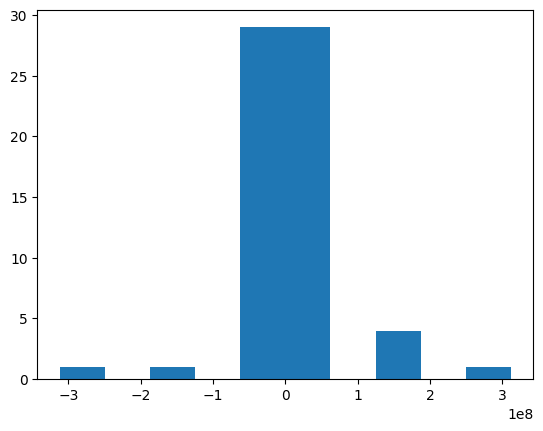

In [75]:
from matplotlib import pyplot as plt

plt.hist(model.coef_)

Сильно переобучились.

Добавим регуляризацию:

*  L1-регуляризация: Lasso
*  L2-регуляризация: Ridge
*  L1+L2: ElasticNet

In [76]:
from sklearn.linear_model import Ridge

model_l2 = Ridge(alpha=1)

model_l2.fit(Xtrain, ytrain)

pred_l2 = model_l2.predict(Xtest)

r2_score(ytest, pred_l2)

0.8315762531853712

In [77]:
r2_score(ytrain, model_l2.predict(Xtrain))

0.9533372679239656

Переобучение снизили!

## Pipeline

In [78]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Разделяем ИСХОДНЫЕ ДАННЫЕ на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.25, random_state=123)

# Преобразование числовых столбцов
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Замена пропусков на среднее
    ('scaler', StandardScaler())  # Масштабирование признаков
])

# Преобразование категориальных столбцов
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),  # Замена пропусков на 'NA'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OHE-кодирование
])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_raw.columns[~cat_features_mask]),
        ('cat', categorical_transformer, X_raw.columns[cat_features_mask])
    ]
)

# Полный пайплайн с линейной регрессией
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1))
])

# 3. Обучение модели
pipeline.fit(X_train, y_train)

# 4. Оценка модели
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"r2 score on test set: {r2:.2f}")

r2 score on test set: 0.86


### Бонус: cреднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения.

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [79]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR
import numpy as np

In [80]:
X[15].values

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [81]:
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

In [82]:
X_subset

array([[0.26037735, 0.        ],
       [0.26037735, 0.        ],
       [0.34339625, 0.        ],
       [0.18113206, 1.        ],
       [0.2830189 , 1.        ],
       [0.2830189 , 1.        ],
       [0.2830189 , 1.        ],
       [0.2830189 , 1.        ],
       [0.26415098, 1.        ],
       [0.1773585 , 0.        ],
       [0.1773585 , 0.        ],
       [0.38867927, 0.        ],
       [0.38867927, 0.        ],
       [0.38867927, 0.        ],
       [0.5584906 , 0.        ],
       [0.5584906 , 0.        ],
       [0.5584906 , 0.        ],
       [0.        , 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.13962264, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.13962264, 0.        ],
       [0.23018868, 0.        ],
       [0.3584906 , 0.        ],
       [0.11698113, 0.        ],
       [0.

In [83]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

Text(0.5, 0, 'x')

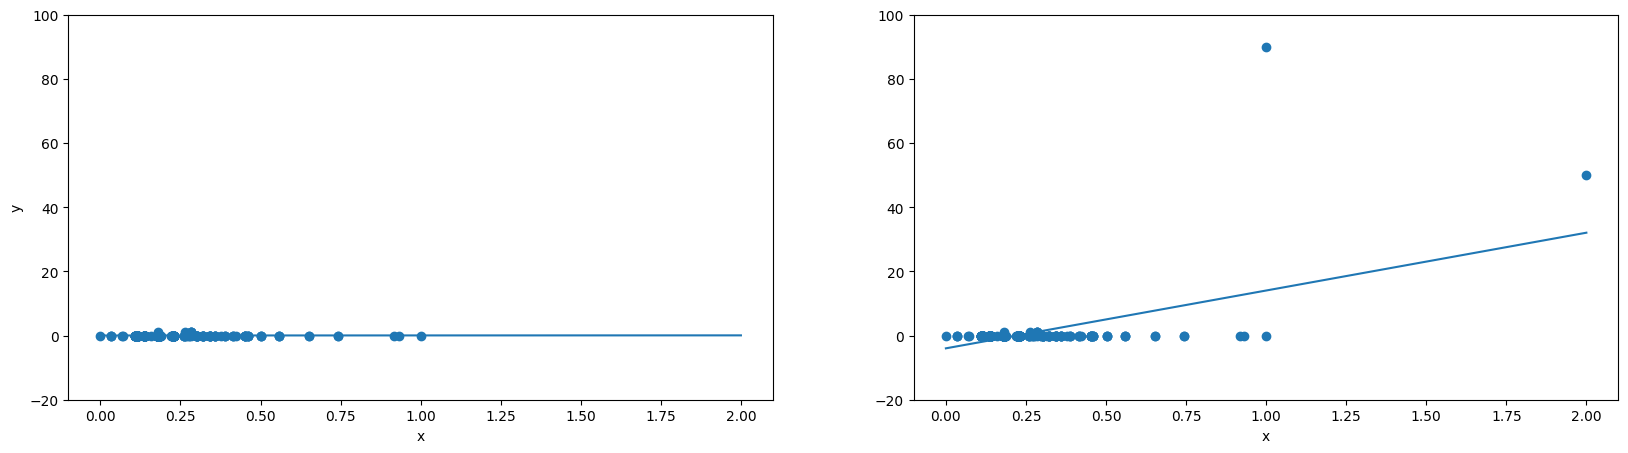

In [84]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [85]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import statsmodels.api as sm

In [86]:
def scatter_points_and_plot_line_MAE(X_subset):
    model = sm.QuantReg(X_subset[:, 1], X_subset[:, 0][:, np.newaxis])
    quantile_regression = model.fit(q=0.5)

    # mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаем зависимость и передаем данные
    # res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки

    grid = np.linspace(0, 2, 100)
    line = quantile_regression.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую
    return model

Text(0.5, 0, 'x')

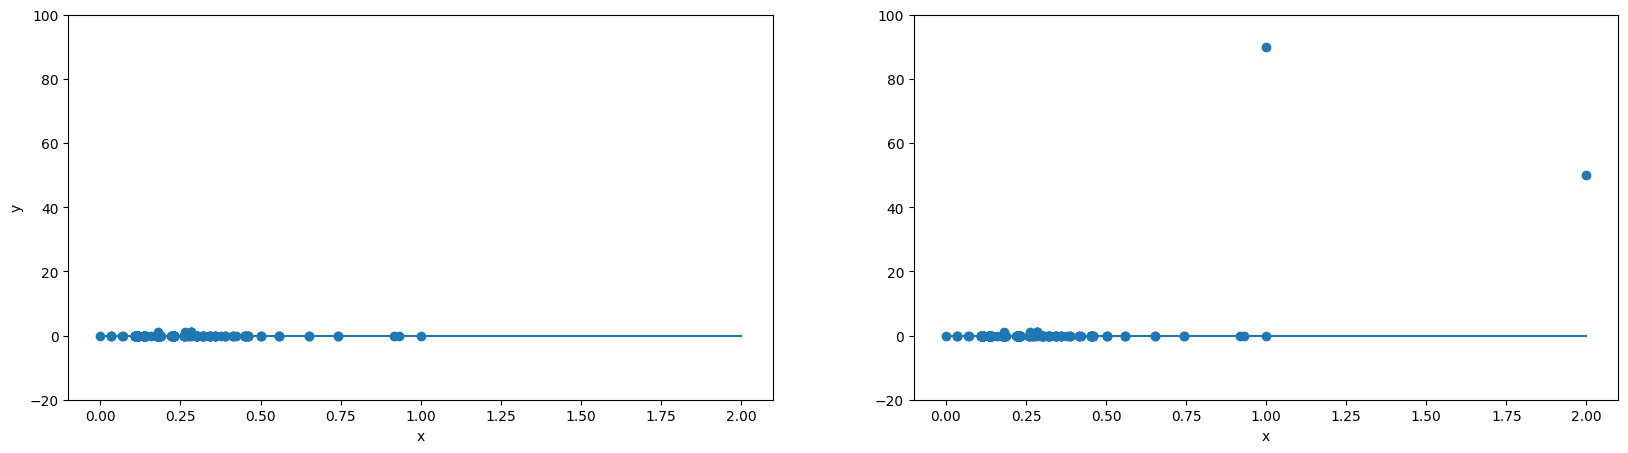

In [87]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [88]:
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2)*[1, 30])) # добавление двух шумовых точек

Text(0.5, 0, 'x')

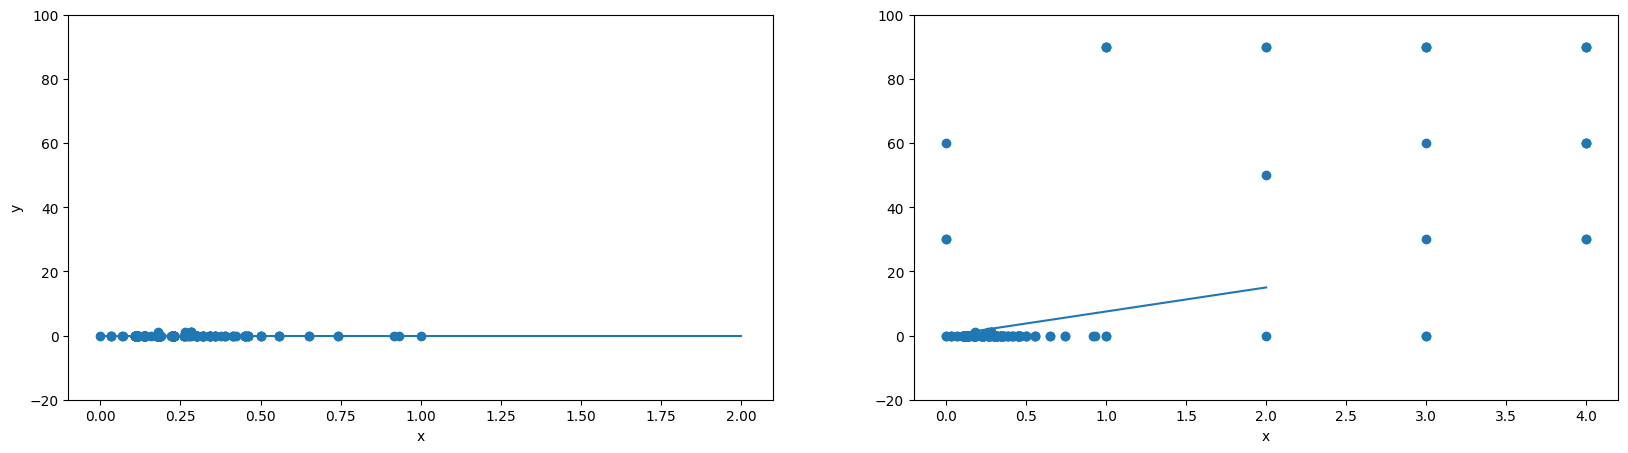

In [89]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.